## Generate data with transient dynamic observations where experiment is concluded at steady state observation

In [1]:
from data.budworm import budworm_ode
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from tqdm.auto import tqdm

In [2]:
def f_true(x):
    return -1*x / (1+x**2)

def g_true(x,k,r):
    return -(r/k)*x**3 + r*x**2 -(r/k)*x +r 
def dg_true(x,k,r):
    return -2*(r/k)*x**2 + 2*r*x - (r/k)

def budworm_steady_states(k,r):
    """
    for a given k and r return real x such that 
    g(x,k:r) = x

    find roots of polynomial 
    p(x) = g(x,k;r)-x = -r/k x^3 + rx^2 -(r/k+1)x+r
    """
    a = -r/k
    b = r
    c=-(r/k + 1)
    d = r
    roots = np.roots([a,b,c,d])

    return sorted([r.real for r in roots if np.isreal(r)])

def converging_steady_state(steady_states,x0):
    if len(steady_states)==3:
        if x0 < steady_states[1]:
            return steady_states[0]
        return steady_states[-1]
    return steady_states[0]

# def get_t_star(x0,xs,r,k,eps=1e-3):
#     lam = f_true(xs)*(1-dg_true(xs,k,r))
#     return 1 / np.abs(lam) * np.log(np.abs(x0-xs)/eps)

## control function

In [3]:
from sympy import symbols, Eq, solve, simplify

r, k = symbols('r k', positive=True)
a = r/k
b = -r
c = (k+r)/k
d = -r
p = (3*a*c-b**2) / (3*a**2)
q = (2*b**3 - 9*a*b*c+27*a**2*d) / (27*a**3)

D = - (4*p**3 + 27*q**2)
D = simplify(D)


D_fixed = D.subs(r, 0.56)
r1, r2 = solve(Eq(D_fixed, 0), k)
print(r1,r2)

k1 = r1-1.1
k2 = r2+1.1

def smooth_k(t):
    A = (k2-k1)/2
    return A*np.sin(t-np.pi/2)+A + k1

6.44569072482332 9.93441120446710


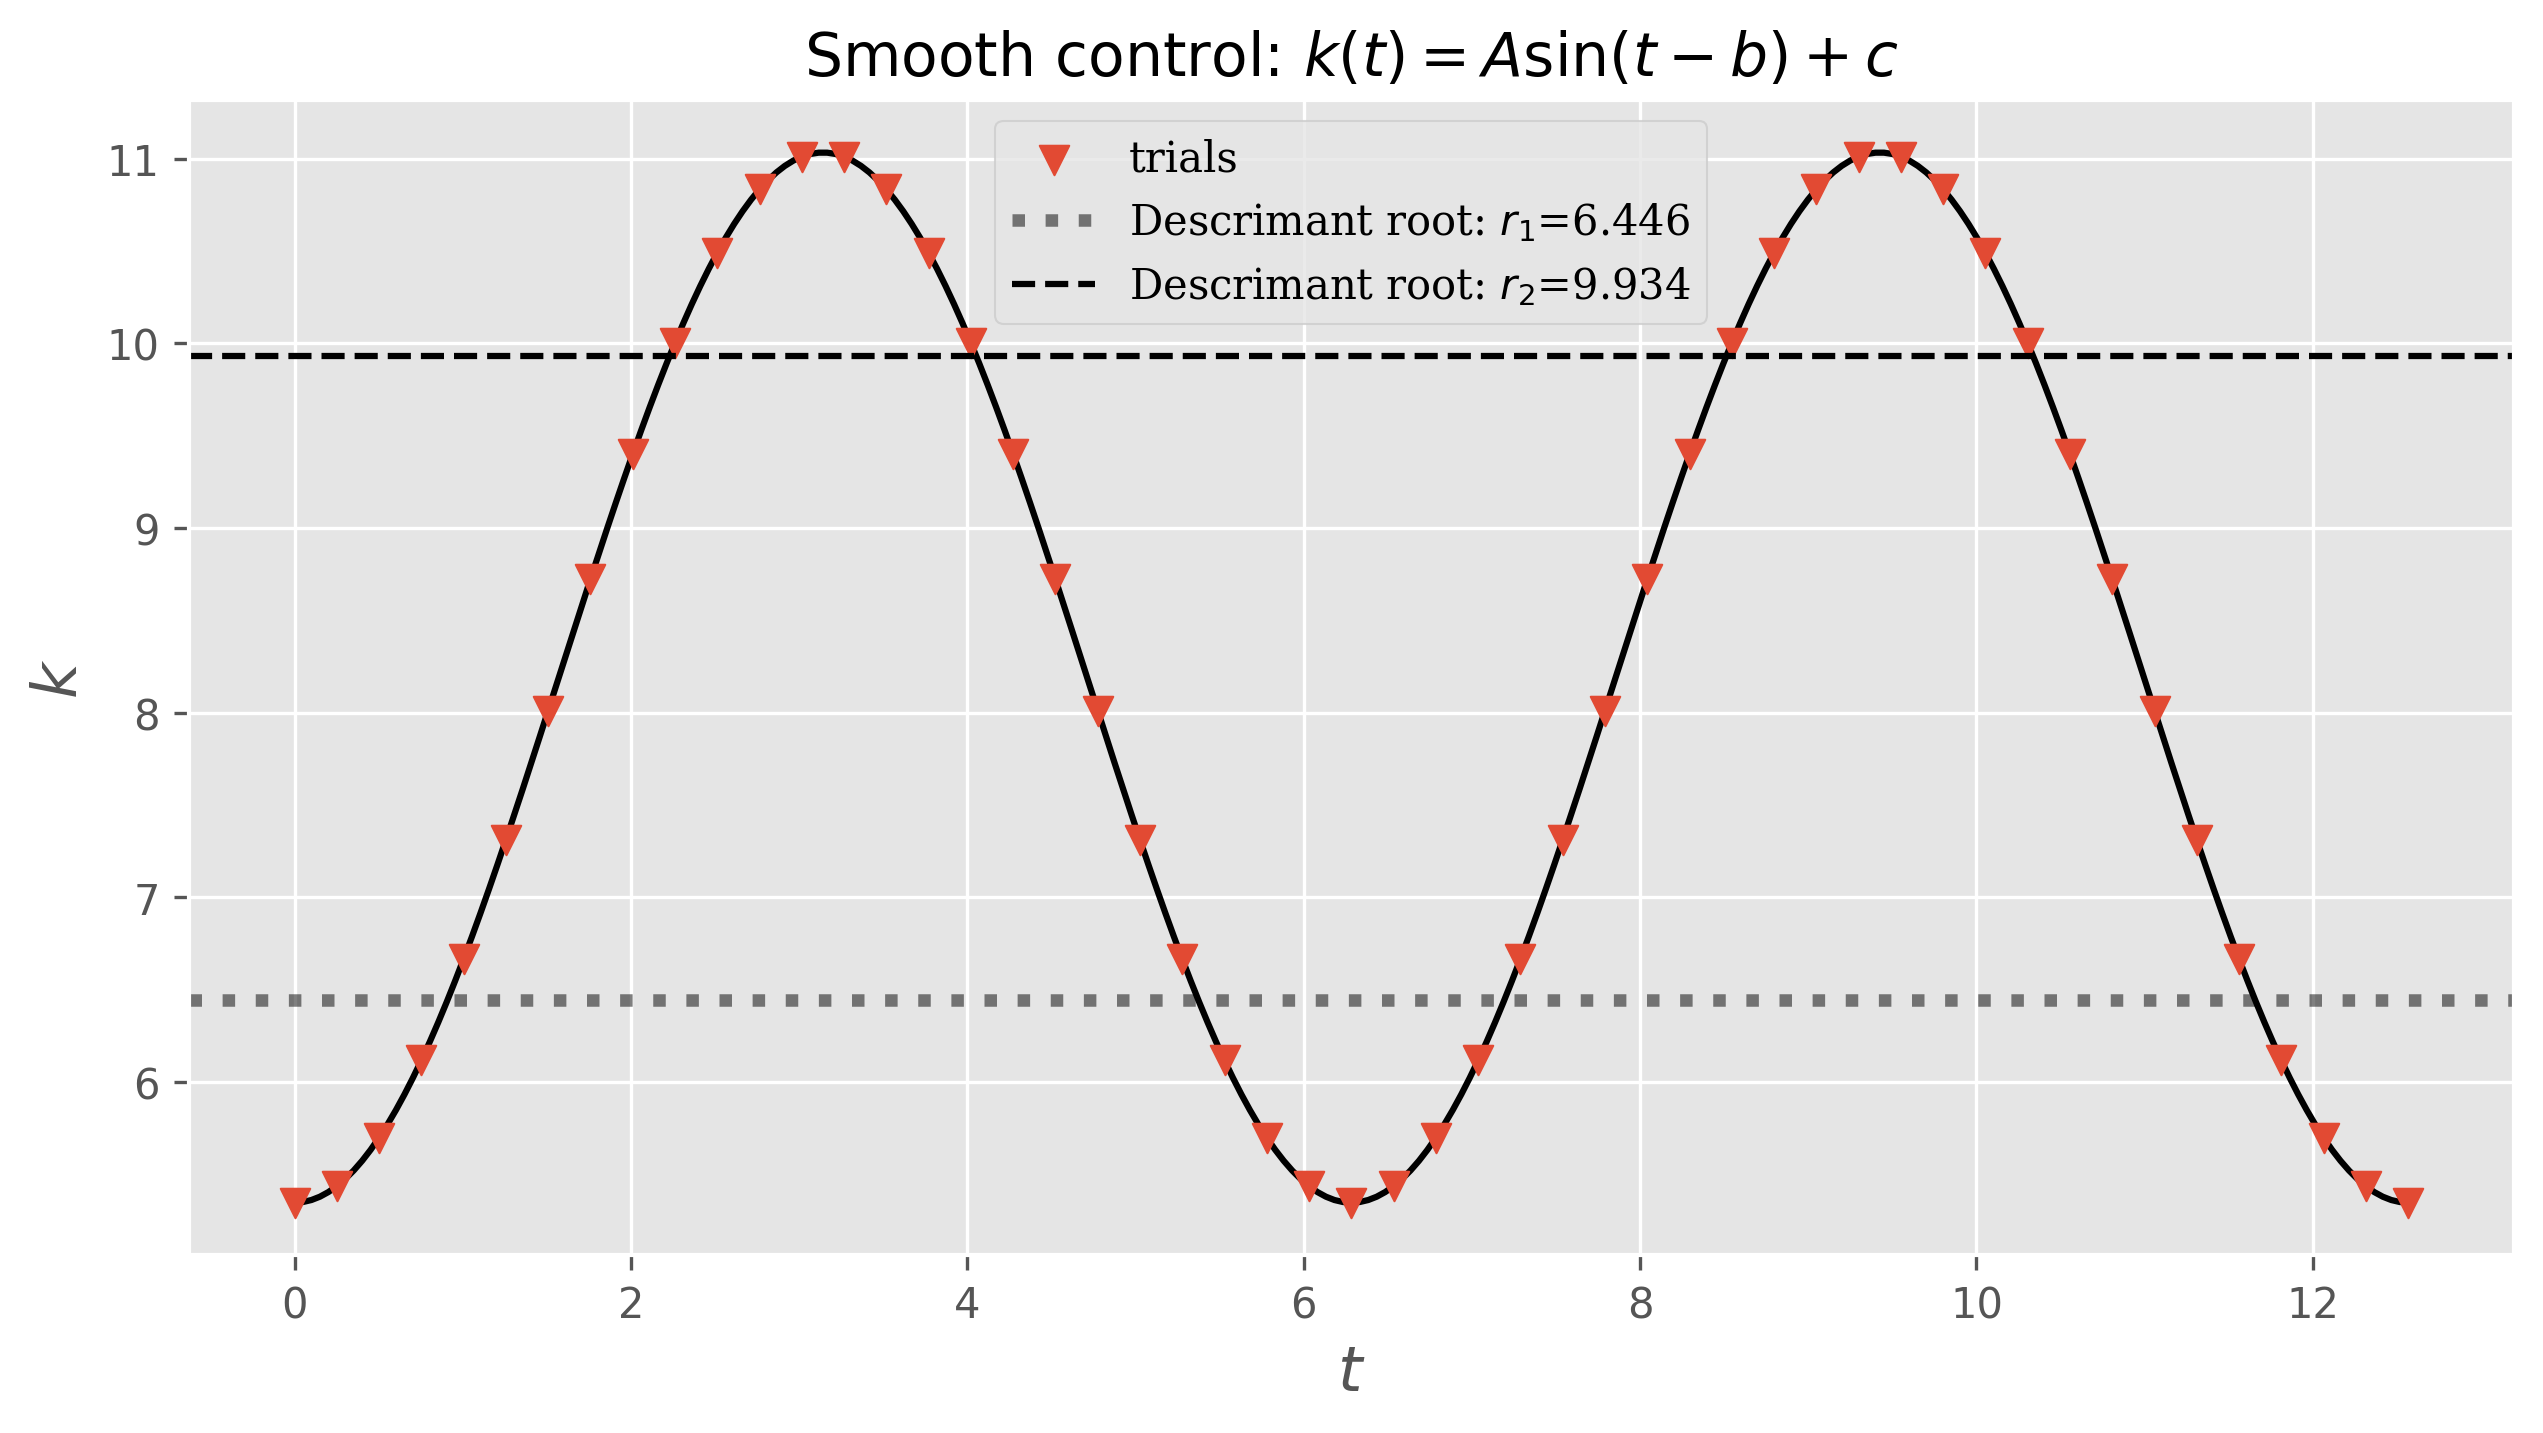

In [4]:
sample_rate = 5
t_span = np.linspace(0,4*np.pi,251)
t_trials = t_span[::sample_rate]
k_true = smooth_k(t_span)
k_trials = smooth_k(t_trials)


fig, ax = plt.subplots(1,1,figsize=(10,5),dpi=300)
t_span = np.linspace(0,4*np.pi,251)

ax.plot(t_span, k_true,c='black',zorder=1)
ax.scatter(
    t_span[::sample_rate],
    k_trials,
    label='trials',
    marker='v',
    s=50,
    zorder=2
)
ax.grid(True)
ax.axhline(r1,linestyle=':',c='black', alpha=0.5,label=rf"Descrimant root: $r_1$={r1:.3f}",lw=3)
ax.axhline(r2, linestyle='--',c='black', label=rf"Descrimant root: $r_2$={r2:.3f}")
ax.set_ylabel(r"$k$", size=15)
ax.set_xlabel(r"$t$",size=15)
ax.set_title(r"Smooth control: $k(t) = A\sin(t-b)+c$")
ax.legend(prop={'family':'serif'})
plt.savefig(f"figures/budworm_smooth_control_{len(k_trials)}_trials.pdf")
plt.show()

In [5]:
# args to pass through 
x0 = 1
ks = k_trials
dt = 0.2
r=0.56
eps=1e-4
buffer = 1e-1

t_max = 400
n_points =701

#inside gen data function

x_curr = x0

x_vals = []
t_vals = []
x_stars = []
t_stars = []
idices = []
for k in tqdm(ks):
    # determine steady state
    xs = budworm_steady_states(k,r)
    x_star = converging_steady_state(xs,x_curr)

    # find time to steady state
    sol = solve_ivp(
        budworm_ode,
        t_span=[0,t_max],
        y0=np.array([x_curr]),
        t_eval=np.linspace(0,t_max,n_points),
        args=(r,k)
    )

    idx_star = np.where(np.abs(sol.y[0,:] - x_star)<eps)[0][0]
    
    t_star = sol.t[idx_star]


    t_end = t_star + buffer
    t_span = [0,t_end]
    t_eval = np.arange(0,t_end, dt)

    

    sol = solve_ivp(
        fun=budworm_ode,
        t_span=t_span,
        y0=np.array([x_curr]),
        t_eval=t_eval,
        args=(r,k)
    )
    out = sol.y
    x_curr = sol.y[0,-1]
    
    idices.append(idx_star)
    x_vals.append(sol.y[0,:])
    t_vals.append(sol.t)
    x_stars.append(x_star)
    t_stars.append(t_star)



  0%|          | 0/51 [00:00<?, ?it/s]

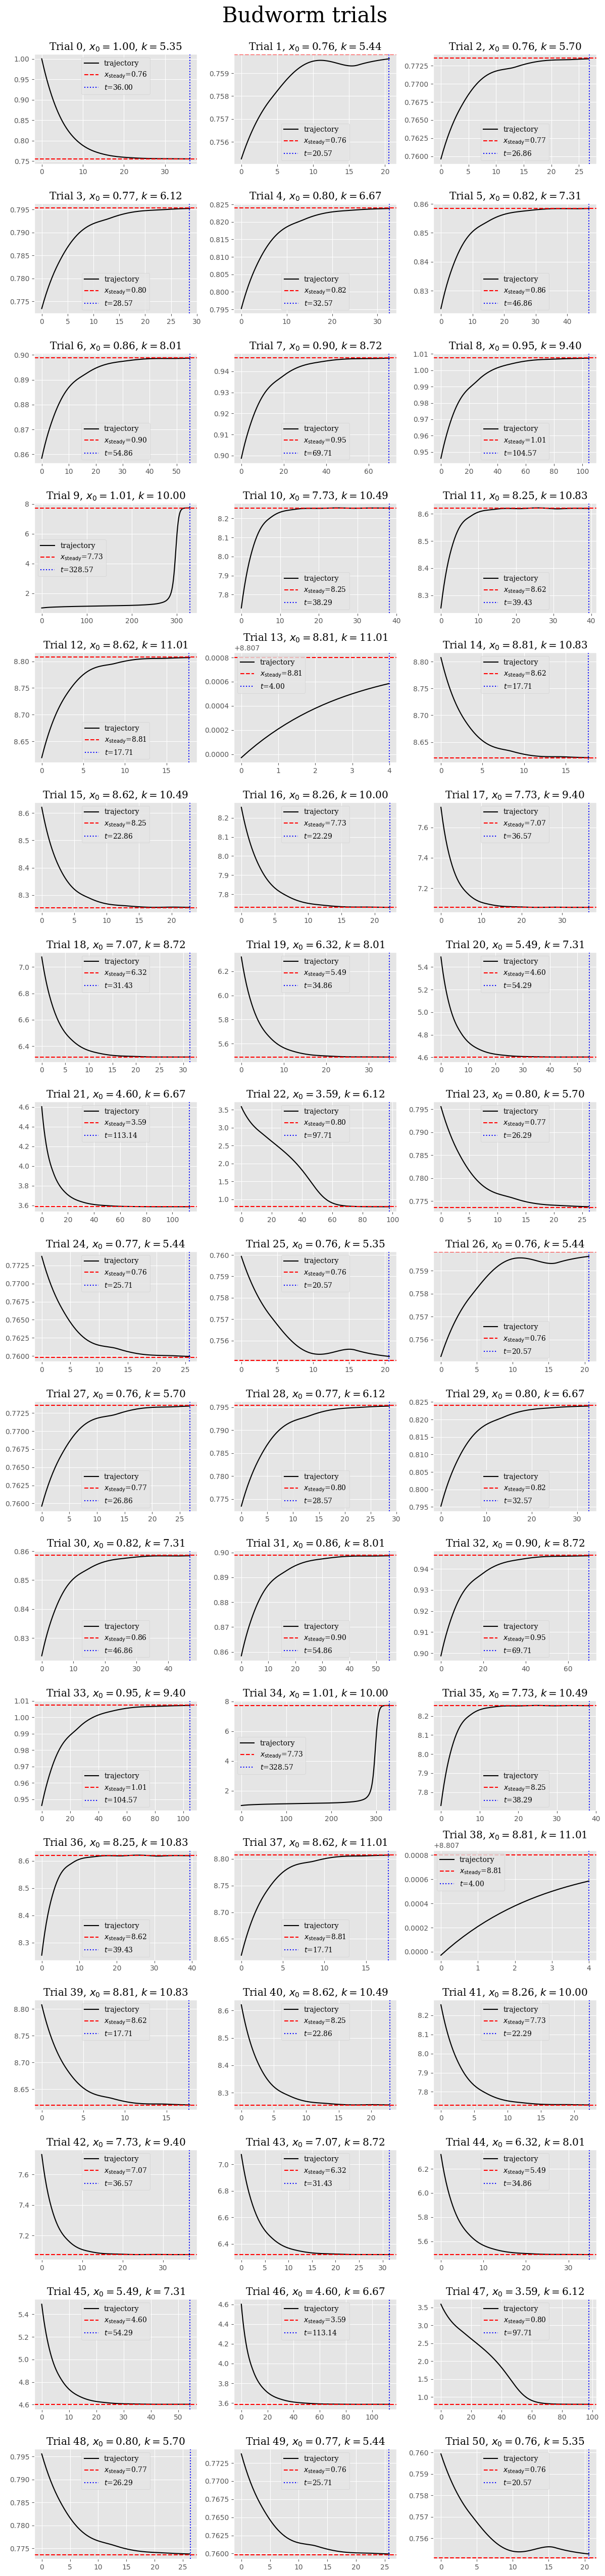

In [6]:
precision = 2
n_plots = len(x_stars)
cols = 3
rows = int(np.ceil(n_plots/cols))

fig, axs = plt.subplots(rows, cols, figsize = (cols*4,rows*3))
axs = axs.flatten()
for idx in range(n_plots):
    x = x_vals[idx]
    t = t_vals[idx]
    xs = x_stars[idx]
    ts = t_stars[idx]

    ax = axs[idx]
    ax.plot(t,x,c='black', label='trajectory')
    ax.axhline(xs,linestyle='--',c='red', label=r"$x_{\text{steady}}$"+f"={xs:.{precision}f}")
    ax.axvline(ts, linestyle=':',c='blue', label=r"$t$="+f"{ts:.{precision}f}")
    ax.legend(prop={'family':'serif'})
    ax.set_title(f"Trial {idx}, "+rf"$x_0=${x[0]:.{precision}f}, " + rf"$k=${k_trials[idx]:.{precision}f}",family='serif')

for idx in range(n_plots,rows*cols):
    fig.delaxes(axs[idx])
fig.suptitle("Budworm trials",family='serif',size=30,y=1.0)
plt.tight_layout()
plt.savefig(f"figures/budworm_{len(k_trials)}_trials.pdf")
plt.show()

## convert to one timeseries

In [7]:
X = np.concatenate(x_vals)

K = []
for k,x in zip(k_trials,x_vals):
    K.append(np.array([k]*len(x)))

K = np.concatenate(K)

T = np.array([dt*i for i in range(len(X))])

trial_idx = np.cumsum([len(x) for x in x_vals]) -1

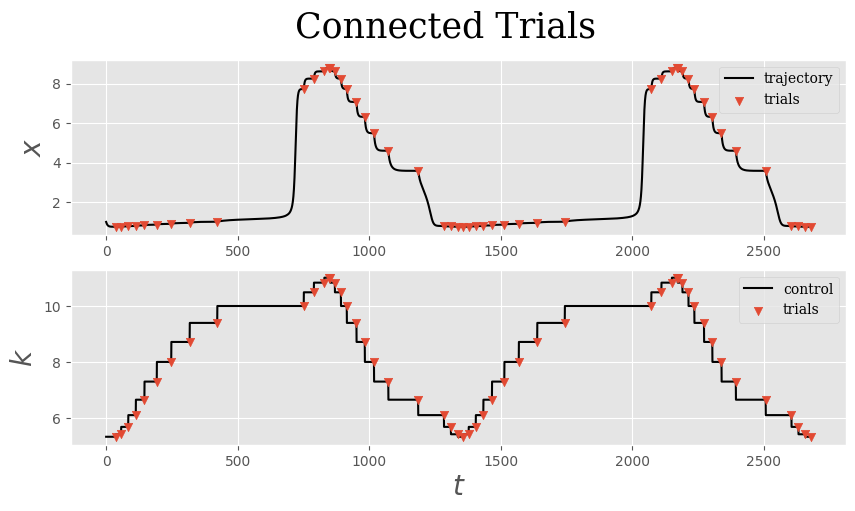

In [8]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,5))
ax1.plot(T,X,c='black', label='trajectory')
ax1.set_ylabel(r"$x$",size=20)
ax1.scatter(T[trial_idx], X[trial_idx],marker='v', zorder=2,label='trials')
ax1.legend(prop={'family':'serif'})

ax2.plot(T,K,c='black',label='control')
ax2.scatter(T[trial_idx], K[trial_idx],marker='v', zorder=2, label='trials')
ax2.set_ylabel(r"$k$",size=20)
ax2.set_xlabel(r"$t$",size=20,family='serif')
ax2.legend(prop={'family':'serif'})

fig.suptitle("Connected Trials", size=25, family='serif')
plt.savefig(f"figures/budworm_connected_{len(k_trials)}_trials.pdf")
plt.show()

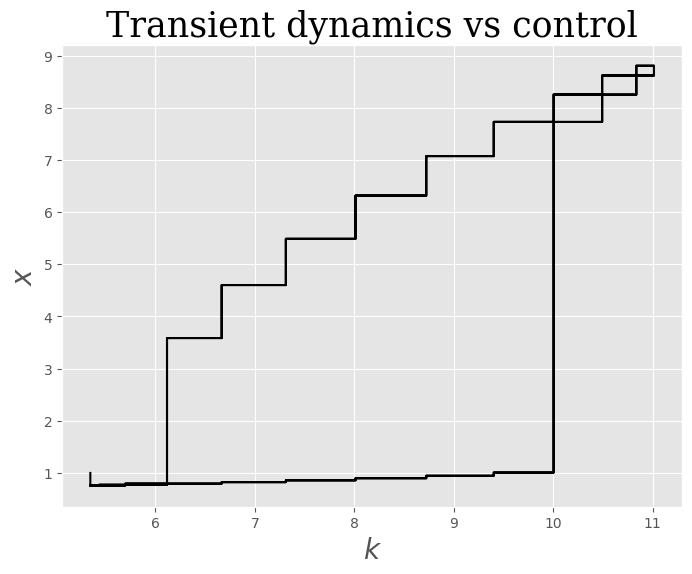

In [9]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(K,X,c='black')
ax.set_xlabel(r"$k$",size=20)
ax.set_ylabel(r"$x$",size=20)
ax.set_title("Transient dynamics vs control", family='serif', size=25)
plt.savefig(f"figures/transient_vs_control_{len(k_trials)}_trials.pdf")
plt.show()